In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Project Overview
This project aims to segment customers based on their sales data using DBSCAN clustering. The goal is to identify distinct customer groups that can help businesses tailor their marketing strategies effectively.

## Dataset
The dataset contains sales data for various customers across different cities. Key columns include:
- `Customer_ID`: Unique identifier for each customer.
- `outlet_city`: City of the outlet.
- `luxury_sales`: Sales of luxury items.
- `fresh_sales`: Sales of fresh items.
- `dry_sales`: Sales of dry items.

# 1. Data Loading

In [2]:
data = pd.read_csv('/content/data.csv')
data.head()

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales
0,10493832.0,Kelaniya,1209.6,756.0,5292.0
1,10178643.0,Moratuwa,1590.12,1060.08,6007.12
2,10513916.0,Wattala,2288.88,1481.04,9155.52
3,10334589.0,Wattala,2274.94,1739.66,9099.76
4,10458365.0,Kelaniya,2345.49,2069.55,9243.99


# 2. Data Cleaning and Preprocessing

## 2.1 Handling Missing Values

In [3]:
# Convert 'null' strings to NaN
data.replace('null', np.nan, inplace=True)
data.replace('nul', np.nan, inplace=True)

In [4]:
# Check for missing values in train and test data
print("Missing values in train data:")
data.isnull().sum()

Missing values in train data:


,0
Customer_ID,2
outlet_city,2
luxury_sales,38
fresh_sales,45
dry_sales,37


In [5]:
len(data)

774155

In [6]:
# Total number of rows in the train dataset
total_rows_train = data.shape[0]

# Percentage of missing values in each column of train data
missing_percentage_train = (data.isnull().sum() / total_rows_train) * 100

print("Percentage of missing values in train data:")
print(missing_percentage_train)

Percentage of missing values in train data:
Customer_ID     0.000258
outlet_city     0.000258
luxury_sales    0.004909
fresh_sales     0.005813
dry_sales       0.004779
dtype: float64


In [7]:
# since the rows with missing values percentage are too small we can remove those
data.dropna(inplace=True)
data.isna().sum()

,0
Customer_ID,0
outlet_city,0
luxury_sales,0
fresh_sales,0
dry_sales,0


## 2.2 Convert our data columns to numerical

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 774053 entries, 0 to 774154
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Customer_ID   774053 non-null  float64
 1   outlet_city   774053 non-null  object 
 2   luxury_sales  774053 non-null  object 
 3   fresh_sales   774053 non-null  object 
 4   dry_sales     774053 non-null  object 
dtypes: float64(1), object(4)
memory usage: 35.4+ MB


In [9]:
# let's try to convert luxury_sales, fresh_sales, dry_sales columns to numerical values
data['luxury_sales'] = data['luxury_sales'].str.replace(',', '').astype(float)
data['fresh_sales'] = data['fresh_sales'].str.replace(',', '').astype(float)
data['dry_sales'] = data['dry_sales'].str.replace(',', '').astype(float)

ValueError: could not convert string to float: 'One thousand four hundread ruppes'

There are rows with string values in these 3 columns

In [10]:
def check_non_numeric_rows(data):
  non_numeric_rows_luxury = data[pd.to_numeric(data['luxury_sales'], errors='coerce').isna()]
  non_numeric_rows_fresh = data[pd.to_numeric(data['fresh_sales'], errors='coerce').isna()]
  non_numeric_rows_dry = data[pd.to_numeric(data['dry_sales'], errors='coerce').isna()]

  #Get the count of non-numeric rows
  count_luxury = len(non_numeric_rows_luxury)
  count_fresh = len(non_numeric_rows_fresh)
  count_dry = len(non_numeric_rows_dry)

  print(f"The number of rows with non-numeric values in 'luxury_sales' column in data is: {count_luxury}")
  print(f"The number of rows with non-numeric values in 'fresh_sales' column in data is: {count_fresh}")
  print(f"The number of rows with non-numeric values in 'dry_sales' column in data is: {count_dry}")

  return non_numeric_rows_luxury, non_numeric_rows_fresh, non_numeric_rows_dry

In [11]:
non_numeric_rows_luxury, non_numeric_rows_fresh, non_numeric_rows_dry = check_non_numeric_rows(data)

The number of rows with non-numeric values in 'luxury_sales' column in data is: 7
The number of rows with non-numeric values in 'fresh_sales' column in data is: 5
The number of rows with non-numeric values in 'dry_sales' column in data is: 1


Again since the counts are too small , we can remove these.

In [12]:
rows_to_delete = non_numeric_rows_luxury.index.union(non_numeric_rows_fresh.index).union(non_numeric_rows_dry.index)
data = data.drop(rows_to_delete)

Let's check again

In [13]:
check_non_numeric_rows(data)

The number of rows with non-numeric values in 'luxury_sales' column in data is: 0
The number of rows with non-numeric values in 'fresh_sales' column in data is: 0
The number of rows with non-numeric values in 'dry_sales' column in data is: 0


(Empty DataFrame
 Columns: [Customer_ID, outlet_city, luxury_sales, fresh_sales, dry_sales]
 Index: [],
 Empty DataFrame
 Columns: [Customer_ID, outlet_city, luxury_sales, fresh_sales, dry_sales]
 Index: [],
 Empty DataFrame
 Columns: [Customer_ID, outlet_city, luxury_sales, fresh_sales, dry_sales]
 Index: [])

In [14]:
data.head()

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales
0,10493832.0,Kelaniya,1209.6,756.0,5292.0
1,10178643.0,Moratuwa,1590.12,1060.08,6007.12
2,10513916.0,Wattala,2288.88,1481.04,9155.52
3,10334589.0,Wattala,2274.94,1739.66,9099.76
4,10458365.0,Kelaniya,2345.49,2069.55,9243.99


In [15]:
# let's try to convert luxury_sales, fresh_sales, dry_sales columns to numerical values
data['luxury_sales'] = data['luxury_sales'].astype(float)
data['fresh_sales'] = data['fresh_sales'].astype(float)
data['dry_sales'] = data['dry_sales'].astype(float)

In [16]:
data.head()

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales
0,10493832.0,Kelaniya,1209.60,756.00,5292.00
1,10178643.0,Moratuwa,1590.12,1060.08,6007.12
2,10513916.0,Wattala,2288.88,1481.04,9155.52
3,10334589.0,Wattala,2274.94,1739.66,9099.76
4,10458365.0,Kelaniya,2345.49,2069.55,9243.99


### Encoding categorical variables and Scaling features

In [17]:
data['outlet_city'].unique()

array(['Kelaniya', 'Moratuwa', 'Wattala', 'Homagama',
       'Dehiwala-Mount Lavinia', 'Panadura', 'Kaduwela', 'Peliyagoda',
       'Kotte', 'Nuwara Eliya', 'Batticaloa', 'Colombo', 'Jaffna',
       'Gampaha', 'Kalmunai', 'Galle', 'Katunayake', 'Negombo',
       'Trincomalee', 'Kandy'], dtype=object)

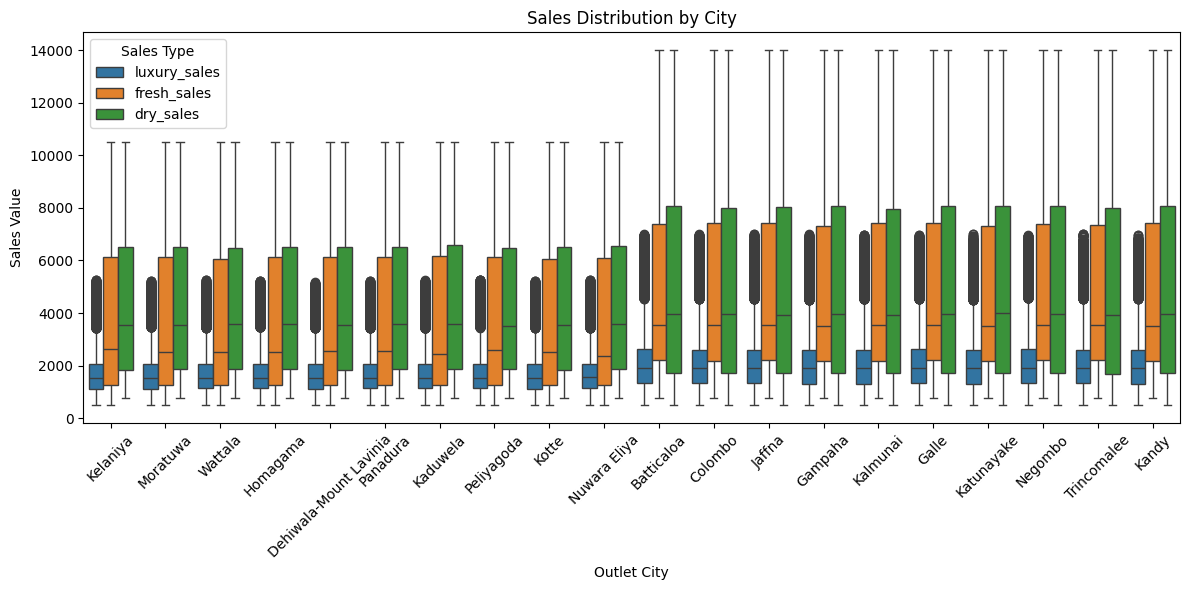

In [18]:
# Melt the DataFrame to long format for seaborn
melted_data = data.melt(id_vars='outlet_city', value_vars=['luxury_sales', 'fresh_sales', 'dry_sales'],
                         var_name='Sales Type', value_name='Sales Value')

# Create a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_data, x='outlet_city', y='Sales Value', hue='Sales Type')
plt.title('Sales Distribution by City')
plt.xticks(rotation=45)
plt.ylabel('Sales Value')
plt.xlabel('Outlet City')
plt.legend(title='Sales Type')
plt.tight_layout()
plt.show()

We can clearly see a pattern in these cities. we can probably divide these cities into two clusters.

In [19]:
# Create a dictionary to store the label for each outlet_city
city_labels_dict = {}

# Determine labels based on dry_sales condition
for city in data['outlet_city'].unique():
    # Check if any dry_sales exceed 12000 for the current city
    if (data[data['outlet_city'] == city]['dry_sales'] > 12000).any():
        city_labels_dict[city] = 1
    else:
        city_labels_dict[city] = 0

city_labels_dict

{'Kelaniya': 0,
 'Moratuwa': 0,
 'Wattala': 0,
 'Homagama': 0,
 'Dehiwala-Mount Lavinia': 0,
 'Panadura': 0,
 'Kaduwela': 0,
 'Peliyagoda': 0,
 'Kotte': 0,
 'Nuwara Eliya': 0,
 'Batticaloa': 1,
 'Colombo': 1,
 'Jaffna': 1,
 'Gampaha': 1,
 'Kalmunai': 1,
 'Galle': 1,
 'Katunayake': 1,
 'Negombo': 1,
 'Trincomalee': 1,
 'Kandy': 1}

In [20]:
# Step to create a new column in the original DataFrame using the dictionary
data['city_label'] = data['outlet_city'].map(city_labels_dict)
data.drop(columns=['outlet_city'], inplace=True)

In [21]:
data.head()

,Customer_ID,luxury_sales,fresh_sales,dry_sales,city_label
0,10493832.0,1209.60,756.00,5292.00,0
1,10178643.0,1590.12,1060.08,6007.12,0
2,10513916.0,2288.88,1481.04,9155.52,0
3,10334589.0,2274.94,1739.66,9099.76,0
4,10458365.0,2345.49,2069.55,9243.99,0


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 774040 entries, 0 to 774154
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Customer_ID   774040 non-null  float64
 1   luxury_sales  774040 non-null  float64
 2   fresh_sales   774040 non-null  float64
 3   dry_sales     774040 non-null  float64
 4   city_label    774040 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 35.4 MB


In [23]:
len(data)

774040

Let's check for outliers

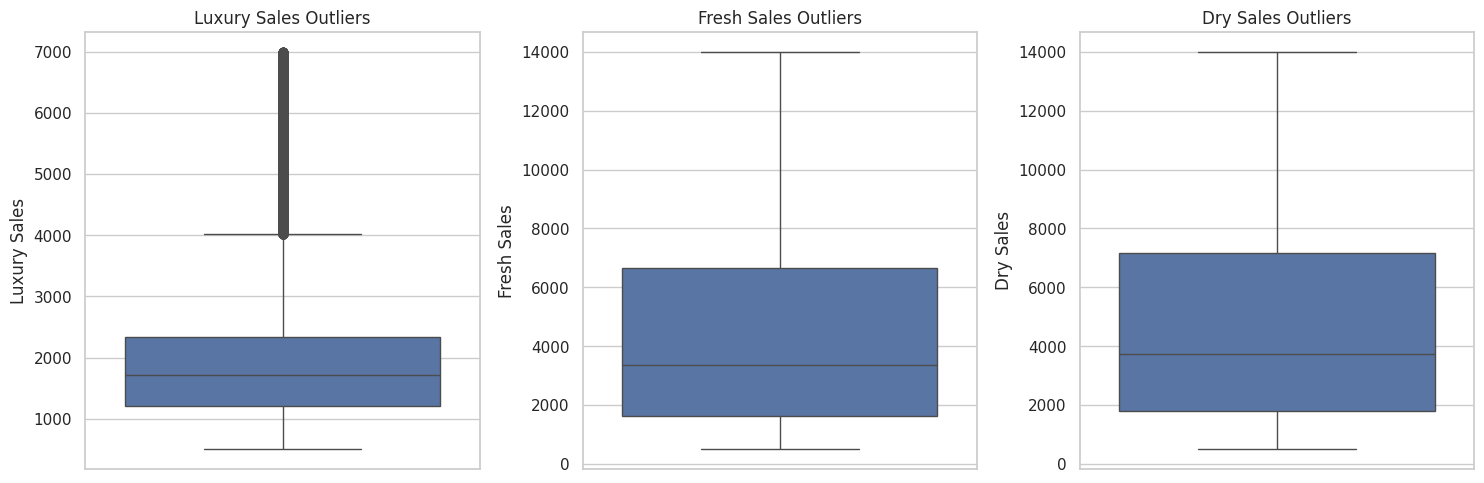

In [24]:
# Set the style of the visualizations
sns.set(style="whitegrid")

# Create a box plot for each sales column
plt.figure(figsize=(15, 5))

# Box plot for luxury_sales
plt.subplot(1, 3, 1)
sns.boxplot(y=data['luxury_sales'])
plt.title('Luxury Sales Outliers')
plt.ylabel('Luxury Sales')

# Box plot for fresh_sales
plt.subplot(1, 3, 2)
sns.boxplot(y=data['fresh_sales'])
plt.title('Fresh Sales Outliers')
plt.ylabel('Fresh Sales')

# Box plot for dry_sales
plt.subplot(1, 3, 3)
sns.boxplot(y=data['dry_sales'])
plt.title('Dry Sales Outliers')
plt.ylabel('Dry Sales')

# Show the plot
plt.tight_layout()
plt.show()

## 2.4 Use Standard Scaling

In [46]:
sample_data = data.sample(n=30000, random_state=42)
# reset index
sample_data.reset_index(drop=True, inplace=True)
X = sample_data.drop(['Customer_ID'], axis=1)

In [47]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

# 3. Model Training

In [48]:
print(X_scaled)

[[-0.38546769  0.51502702 -1.10852041  0.94434614]
 [ 0.18364108 -0.89450759  0.77768883 -1.05893375]
 [-0.23483467 -0.83665158 -0.90831801  0.94434614]
 ...
 [-0.29541319  0.4885337  -0.97581104  0.94434614]
 [ 0.59255598  1.48899946 -0.9211762   0.94434614]
 [ 2.0770073  -0.04615701 -0.15664977  0.94434614]]


## 3.1 DBSCAN

In [66]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.4, min_samples=50)
clusters = dbscan.fit_predict(X_scaled)
sample_data['Cluster'] = clusters

# Count number of points in each cluster
cluster_counts = sample_data['Cluster'].value_counts()

print("Cluster counts:\n", cluster_counts)

Cluster counts:
 Cluster
5    7338
1    6692
0    6618
3    5932
2    1902
4    1518
Name: count, dtype: int64


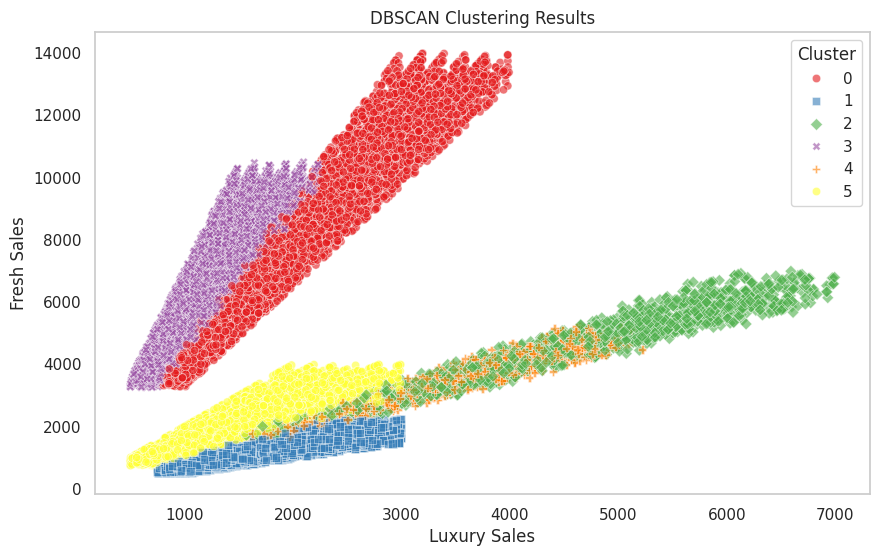

In [67]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sample_data, x='luxury_sales', y='fresh_sales', hue='Cluster', palette='Set1', style='Cluster', markers=["o", "s", "D", "X", "P"], alpha=0.6)
plt.title('DBSCAN Clustering Results')
plt.xlabel('Luxury Sales')
plt.ylabel('Fresh Sales')
plt.legend(title='Cluster')
plt.grid()
plt.show()

In [68]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

filtered_data = sample_data[sample_data['Cluster'] != -1]
if len(filtered_data) > 1:
    silhouette_avg = silhouette_score(X_scaled[filtered_data.index], filtered_data['Cluster'])
    print(f'Silhouette Score: {silhouette_avg:.4f}')
else:
    print("Not enough points for Silhouette Score calculation.")

if len(filtered_data) > 1:
    db_index = davies_bouldin_score(X_scaled[filtered_data.index], filtered_data['Cluster'])
    print(f'Davies-Bouldin Index: {db_index:.4f}')
else:
    print("Not enough points for Davies-Bouldin Index calculation.")


Silhouette Score: 0.5081
Davies-Bouldin Index: 0.8912


In [72]:
# Calculate summary statistics for each cluster
cluster_summary = sample_data.groupby('Cluster')[['luxury_sales', 'fresh_sales', 'dry_sales']].agg(['mean', 'median', 'count'])
cluster_summary


luxury_sales                  fresh_sales                  \
                mean    median count         mean    median count   
Cluster                                                             
0        2180.704932  2145.085  6618  8410.850063  8338.960  6618   
1        1756.612149  1748.800  6692  1257.849619  1235.300  6692   
2        4105.041209  4083.080  1902  4106.743985  4117.590  1902   
3        1243.047222  1218.775  5932  6725.599405  6662.670  5932   
4        3229.000099  3230.850  1518  3234.166686  3239.375  1518   
5        1556.560424  1526.140  7338  2175.800775  2149.330  7338   

           dry_sales                  
                mean    median count  
Cluster                               
0        1555.370870  1526.475  6618  
1        6776.495892  6731.700  6692  
2        4096.504932  4065.095  1902  
3        1745.982365  1723.950  5932  
4        3234.122767  3236.760  1518  
5        8392.213186  8332.250  7338

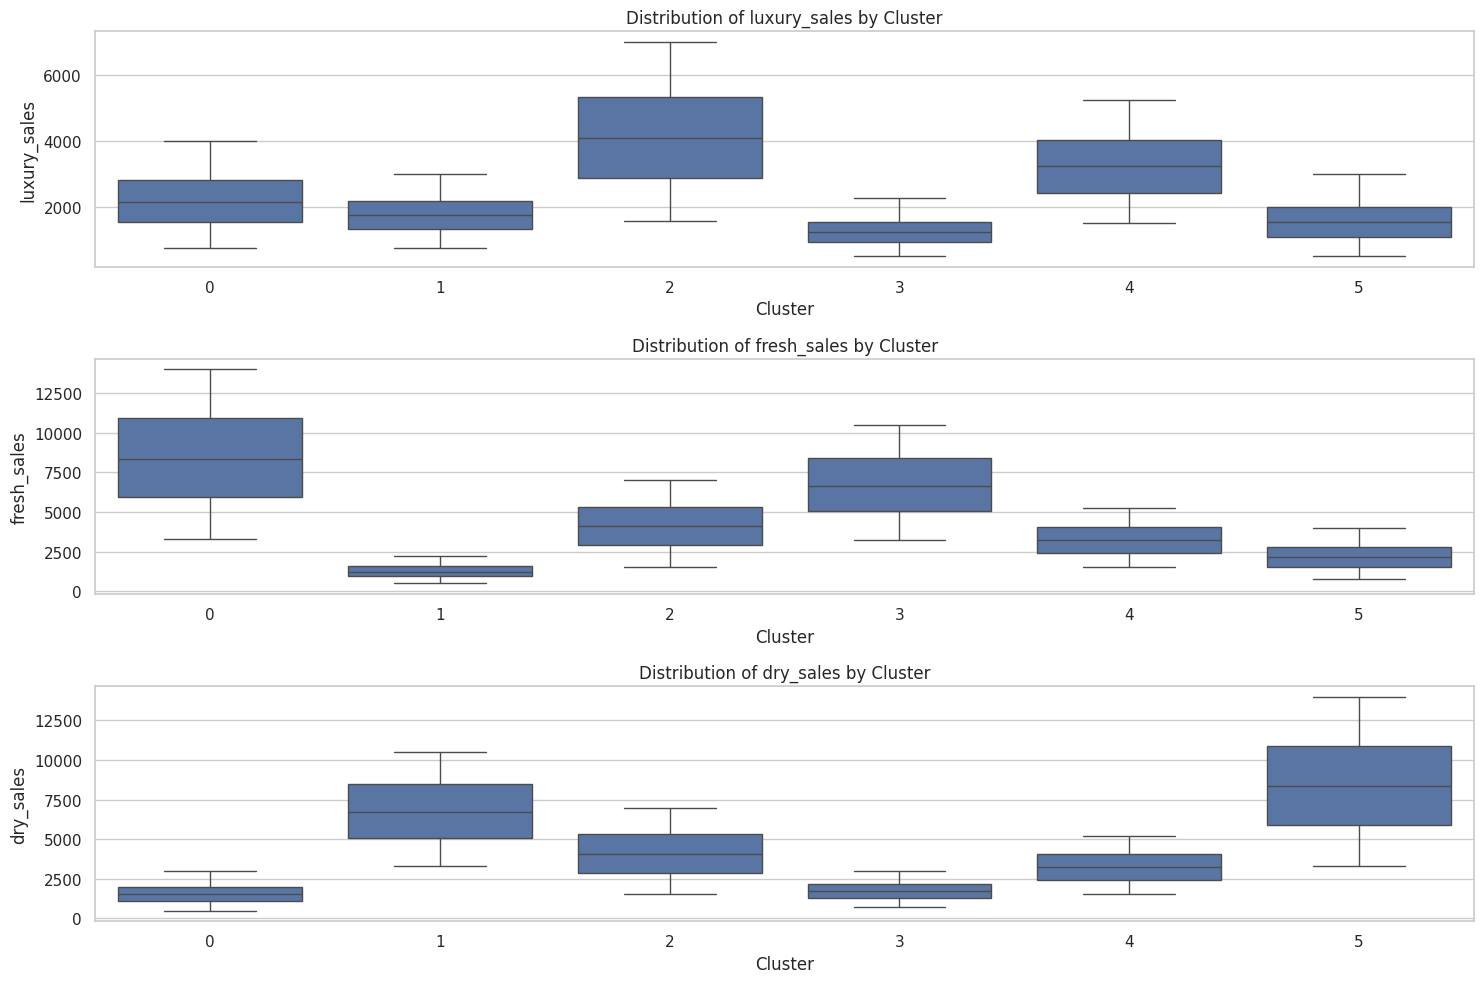

In [74]:
# Visualize the sales distribution in each cluster using boxplots
plt.figure(figsize=(15, 10))
for i, sales_type in enumerate(['luxury_sales', 'fresh_sales', 'dry_sales']):
    plt.subplot(3, 1, i + 1)
    sns.boxplot(x='Cluster', y=sales_type, data=sample_data)
    plt.title(f'Distribution of {sales_type} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(sales_type)

# Adjust the space between subplots
plt.subplots_adjust(hspace=0.4)

plt.tight_layout()
plt.show()


## Cluster Analysis

### Cluster 0:
- **Luxury Sales**: Higher than average luxury sales compared to other clusters.
- **Fresh Sales**: Very high fresh sales, indicating potential demand.
- **Dry Sales**: Lowest dry sales among all clusters.
- **Recommendation**: Focus on increasing dry sales by promoting dry goods. Bundle dry goods with luxury and fresh products to attract more buyers. Consider loyalty programs to reward high-spending customers on luxury and fresh items.

### Cluster 1:
- **Luxury Sales**: Lower luxury sales compared to other clusters.
- **Fresh Sales**: Lowest fresh sales among all clusters.
- **Dry Sales**: High dry sales compared to luxury and fresh.
- **Recommendation**: Focus on improving fresh and luxury product sales through discounts or targeted promotions. Consider bundling dry goods, which are performing well, with fresh and luxury products to encourage trial and boost sales in these categories.

### Cluster 2:
- **Luxury Sales**: Highest luxury sales among all clusters.
- **Fresh Sales**: Moderate fresh sales.
- **Dry Sales**: Moderate dry sales.
- **Recommendation**: Maintain focus on luxury products by offering exclusive deals or early access to premium customers. Explore opportunities to improve fresh and dry sales through cross-category promotions or incentivizing multi-category purchases.

### Cluster 3:
- **Luxury Sales**: Very low luxury sales.
- **Fresh Sales**: High fresh sales.
- **Dry Sales**: Very low dry sales.
- **Recommendation**: Aggressively market luxury and dry products to this segment, as fresh sales are already strong. Introduce affordable luxury items and bundle them with fresh goods to encourage spending in the other categories. Dry products may also benefit from discounts or special promotions to raise their appeal.

### Cluster 4:
- **Sales**: Moderate sales across all categories.
- **Recommendation**: Capitalize on the balanced buying behavior by offering bundle promotions across luxury, fresh, and dry goods. This cluster may be highly receptive to loyalty programs or cross-category discounts to maintain and increase spending.

### Cluster 5:
- **Luxury Sales**: Very low luxury sales.
- **Fresh Sales**: Moderate fresh sales.
- **Dry Sales**: Highest dry sales among all clusters.
- **Recommendation**: Promote luxury products more aggressively, as they have the lowest performance in this cluster. Consider introducing luxury products at more accessible price points to attract these customers. Additionally, capitalize on strong dry sales with promotions and offers that bundle fresh and luxury products with dry goods.
